In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = '/Users/Gregs_Computer/Documents/Studies/Data Science/Projects/Hands-On Machine Learning with Scikit Learn and Tensorflow/'
CHAPTER_ID = 'ensembles'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + '.png', format='png', dpi=300)


# Ensemble Learning and Random Forests

Suppose you ask a complex question to thousands of random people, then aggregate
their answers. In many cases you will find that this aggregated answer is better than
an expert’s answer. This is called the *wisdom of the crowd*. Similarly, if you aggregate
the predictions of a group of predictors (such as classifiers or regressors), you will
often get better predictions than with the best individual predictor. A group of pre‐
dictors is called an *ensemble*; thus, this technique is called *Ensemble Learning*, and an Ensemble Learning algorithm is called an *Ensemble method*.

For example, you can train a group of Decision Tree classifiers, each on a different
random subset of the training set. To make predictions, you just obtain the predic‐
tions of all individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a *Random Forest*, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.

Moreover, we will often use Ensemble methods near the end of a project, once we have already built a few good predictors, to combine them into an even better predictor. In fact, the winning solutions in Machine Learn‐
ing competitions often involve several Ensemble methods (most famously in the Netflix Prize competition).

In this chapter, we will discuss the most popular Ensemble methods, including *bagging, boosting, stacking*, and a few others. We will also explore Random Forests.

# Voting Classifiers

Suppose we have trained a few classifiers, each one achieving about 80% accuracy. We may have a Logistic Regression classifier, an SVM classifier, a Random Forest Classifier, a K-Nearest Neighbors classifier, and perhaps a few more.

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. A majority-vote classifier is called a *hard voting* classifier.

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the
best classifier in the ensemble. In fact, even if each classifier is a *weak learner* (meaning it does only slightly better than random guessing), the ensemble can still be a *strong learner* (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on this mystery.
Suppose you have a slightly biased coin that has a 51% chance of coming up heads,
and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get
more or less 510 heads and 490 tails, and hence a majority of heads. If you do the
math, you will find that the probability of obtaining a majority of heads after 1,000
tosses is close to 75%. The more you toss the coin, the higher the probability (e.g.,
with 10,000 tosses, the probability climbs over 97%). This is due to the *law of large
numbers*: as you keep tossing the coin, the ratio of heads gets closer and closer to the
probability of heads (51%). The figure below shows 10 series of biased coin tosses. We can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up so close to 51% that they are consistently above 50%.

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1,1)

In [3]:
print(coin_tosses)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 1 1]
 [0 1 1 ... 0 0 1]
 ...
 [1 1 0 ... 1 1 0]
 [0 0 1 ... 1 1 1]
 [0 1 0 ... 0 1 1]]


In [4]:
print(cumulative_heads_ratio)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.5        0.5       ]
 [0.66666667 0.33333333 0.33333333 ... 0.         0.33333333 0.66666667]
 ...
 [0.51140228 0.5115023  0.50680136 ... 0.5095019  0.51070214 0.51010202]
 [0.51135114 0.51145115 0.50685069 ... 0.50955096 0.51075108 0.51015102]
 [0.5113     0.5115     0.5068     ... 0.5095     0.5108     0.5102    ]]


Saving figure law_of_large_numbers_plot


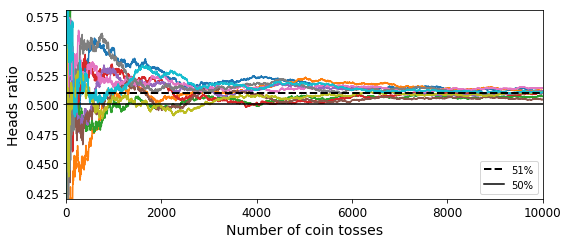

In [5]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy! However, this is
only true if all classifiers are perfectly independent, making uncorrelated errors,
which is clearly not the case since they are trained on the same data. They are likely to
make the same types of errors, so there will be many majority votes for the wrong
class, reducing the ensemble’s accuracy.

**Note**: Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble's accuracy.

The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers (the training set is the moons dataset):

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Note**: to be future-proof we set solver='lbfgs', n_estimators=100, and gamma='scale' since these will be the default values in upcoming sklearn versions.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

Let's look at each classifier's accuracy on the test set:

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.904


This voting classifier slightly outperforms all the individual classifiers.

If all classifiers are able to estimate class probabilities (ie they have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called *soft voting*. It often achieves higher performance than hard voting because it gives more
weight to highly confident votes. All you need to do is replace voting="hard" with
voting="soft" and ensure that all classifiers can estimate class probabilities. This is
not the case of the SVC class by default, so you need to set its probability hyperpara‐
meter to True (this will make the SVC class use cross-validation to estimate class prob‐
abilities, slowing down training, and it will add a predict_proba() method). If you modify the preceding code to use soft voting, you will find that the voting classifier
achieves over 91.2% accuracy!

We will now modify the above code to ensure each classifier has a predict_proba() method, and change it to soft voting:

In [9]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [10]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.912


# Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every
predictor, but to train them on different random subsets of the training set. When
sampling is performed *with* replacement, this method is called *bagging* (short for *bootstrap aggregating*). When sampling is performed *without* replacement, it is called *pasting*.

In other words, both bagging and pasting allow training instances to be sampled sev‐
eral times across multiple predictors, but only bagging allows training instances to be
sampled several times for the same predictor.

Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. The aggregation
function is typically the *statistical mode* (ie the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but
aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a **similar bias** but a **lower variance** than a single predictor trained on the
original training set.

Predictors can all be trained in parallel, via different
CPU cores or even different servers. Similarly, predictions can be made in parallel.
This is one of the reasons why bagging and pasting are such popular methods: they
scale very well.

What's the difference between bagging and pasting?

### Bagging and Pasting in Scikit-Learn

Sklearn offers a simple API for both bagging and pasting with the BaggingClassifier class (or BaggingRegressor for regression). The following code trains an
ensemble of 500 Decision Tree classifiers, each trained on 100 training instances ran‐
domly sampled from the training set with replacement (this is an example of bagging,
but if you want to use pasting instead, just set bootstrap=False). The n_jobs param‐
eter tells Scikit-Learn the number of CPU cores to use for training and predictions
(–1 tells Scikit-Learn to use all available cores).

**Note**: max_samples can alternatively be set to a float between 0.0 and 1.0, in which case the max number of instances to sample is equal to the size of the training set times max_samples.

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

**Note**: The BaggingClassifier automatically performs soft voting
instead of hard voting if the base classifier can estimate class proba‐
bilities (i.e., if it has a predict_proba() method), which is the case
with Decision Trees classifiers.

In [12]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [13]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


The figure below compares the decision boundary of a single Decision Tree with the deci‐
sion boundary of a bagging ensemble of 500 trees (from the preceding code), both
trained on the moons dataset. As you can see, the ensemble’s predictions will likely
generalize much better than the single Decision Tree’s predictions: the ensemble has a
comparable bias but a smaller variance (it makes roughly the same number of errors
on the training set, but the decision boundary is less irregular).

In [14]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


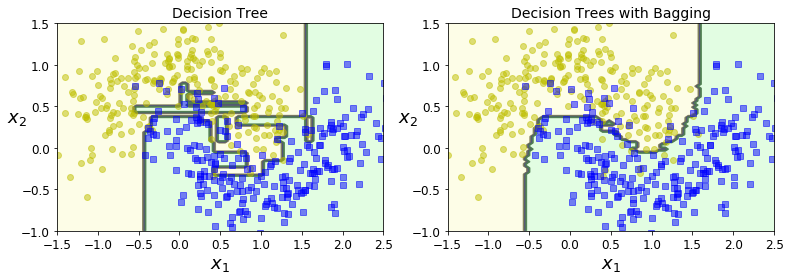

In [15]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

Bootstrapping introduces a bit more diversity in the subsets that each predictor is
trained on, so bagging ends up with a slightly higher bias than pasting, but this also
means that predictors end up being less correlated so the ensemble’s variance is
reduced. Overall, bagging often results in better models, which explains why it is gen‐
erally preferred. However, if you have spare time and CPU power you can use crossvalidation to evaluate both bagging and pasting and select the one that works best.

### Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor,
while others may not be sampled at all. By default a BaggingClassifier samples m
training instances with replacement (bootstrap=True), where m is the size of the
training set. This means that only about 63% of the training instances are sampled on
average for each predictor. The remaining 37% of the training instances that are not
sampled are called *out-of-bag* (oob) instances. Note that they are not the same 37% for all predictors.

Since a predictor never sees the oob instances during training, it can be evaluated on
these instances, without the need for a separate validation set. You can evaluate the
ensemble itself by **averaging out the oob evaluations of each predictor**.

In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to
request an automatic oob evaluation after training. The following code demonstrates
this. The resulting evaluation score is available through the oob_score_ variable:

In [16]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16,
                          random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True,
    n_jobs=-1, oob_score=True, random_state=42)

In [17]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [18]:
bag_clf.oob_score_

0.92

According to this oob evaluation, this BaggingClassifier is likely to achieve about 90.1% accuracy on the test set. Let's verify this:

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.92

The oob decision function for each training instance is also available through the
oob_decision_function_ variable. In this case (since the base estimator has a pre
dict_proba() method) the decision function returns the class probabilities for each
training instance. For instance, the oob evaluation evaluates that the first training instance has a 66.37% probability of belonging to the positive class (and 33.63% of belonging to the negative class):

In [20]:
bag_clf.oob_decision_function_

array([[0.33626854, 0.66373146],
       [0.43163909, 0.56836091],
       [0.97257271, 0.02742729],
       [0.04502706, 0.95497294],
       [0.0695281 , 0.9304719 ],
       [0.09709608, 0.90290392],
       [0.41407805, 0.58592195],
       [0.17752701, 0.82247299],
       [0.937834  , 0.062166  ],
       [0.73921041, 0.26078959],
       [0.54193633, 0.45806367],
       [0.09526283, 0.90473717],
       [0.6781065 , 0.3218935 ],
       [0.81490472, 0.18509528],
       [0.9282137 , 0.0717863 ],
       [0.06632783, 0.93367217],
       [0.11161598, 0.88838402],
       [0.90884172, 0.09115828],
       [0.66589703, 0.33410297],
       [0.9243182 , 0.0756818 ],
       [0.05374201, 0.94625799],
       [0.19765981, 0.80234019],
       [0.85557724, 0.14442276],
       [0.92135537, 0.07864463],
       [0.9574264 , 0.0425736 ],
       [0.04625719, 0.95374281],
       [0.91722591, 0.08277409],
       [0.93443863, 0.06556137],
       [0.08294428, 0.91705572],
       [0.74755535, 0.25244465],
       [0.

### Random Patches and Random Subspaces

The BaggingClassifier class supports sampling the features as well. This is con‐
trolled by two hyperparameters: max_features and bootstrap_features. They work
the same way as max_samples and bootstrap, but for feature sampling instead of
instance sampling. Thus, each predictor will be trained on a random subset of the
input features.

This is particularly useful when you are dealing with high-dimensional inputs (such
as images). Sampling both training instances and features is called the *Random Patches* method. Keeping all training instances (i.e., bootstrap=False and max_sam
ples=1.0) but sampling features (i.e., bootstrap_features=True and/or max_fea
tures smaller than 1.0) is called the *Random Subspaces* method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

# Random Forests

As we have discussed, a Random Forest is an ensemble of Decision Trees, generally
trained via the bagging method (or sometimes pasting), typically with max_samples
set to the size of the training set. Instead of building a BaggingClassifier and pass‐
ing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier
class, which is more convenient and optimized for Decision Trees (similarly, there is a RandomForestRegressor class for regression tasks). The following code trains a
Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using
all available CPU cores:

In [21]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [22]:
np.sum(y_pred == y_pred_rf) / len(y_pred) # almost identical predictions

0.976

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a
DecisionTreeClassifier (to control how trees are grown), plus all the hyperpara‐
meters of a BaggingClassifier to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees;
instead of searching for the very best feature when splitting a node (see Chapter 6), it
searches for the best feature among a random subset of features. This results in a
greater tree diversity, which (once again) trades a higher bias for a lower variance,
generally yielding an overall better model. The following BaggingClassifier is
roughly equivalent to the previous RandomForestClassifier:

In [23]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### Extra-Trees

When you are growing a tree in a Random Forest, at each node only a random subset
of the features is considered for splitting (as discussed earlier). It is possible to make
trees even more random by also using random thresholds for each feature rather than
searching for the best possible thresholds (like regular Decision Trees do).

A forest of such extremely random trees is simply called an *Extremely Randomized Trees* ensemble (or *Extra-Trees* for short). Once again, this trades more bias for a
lower variance. It also makes Extra-Trees much faster to train than regular Random
Forests since finding the best possible threshold for each feature at every node is one
of the most time-consuming tasks of growing a tree.

You can create an Extra-Trees classifier using Scikit-Learn’s ExtraTreesClassifier
class. Its API is identical to the RandomForestClassifier class. Similarly, the Extra
TreesRegressor class has the same API as the RandomForestRegressor class.

**Note**: It is hard to tell in advance whether a RandomForestClassifier
will perform better or worse than an ExtraTreesClassifier. Gen‐
erally, the only way to know is to try both and compare them using
cross-validation (and tuning the hyperparameters using grid
search).

### Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure the
relative importance of each feature. Scikit-Learn measures a feature’s importance by
looking at how much the tree nodes that use that feature reduce impurity on average
(across all trees in the forest). More precisely, it is a weighted average, where each
node’s weight is equal to the number of training samples that are associated with it
(see Chapter 6).

Scikit-Learn computes this score automatically for each feature after training, then it
scales the results so that the sum of all importances is equal to 1. You can access the
result using the feature_importances_ variable. For example, the following code
trains a RandomForestClassifier on the iris dataset (introduced in Chapter 4) and
outputs each feature’s importance. It seems that the most important features are the
petal length (44%) and width (42%), while sepal length and width are rather unim‐
portant in comparison (11% and 2%, respectively).

In [24]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [25]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

We can also train a Random Forest classifier on the MNIST dataset and plot each pixel's importance on a heatmap.

In [26]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [27]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [28]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


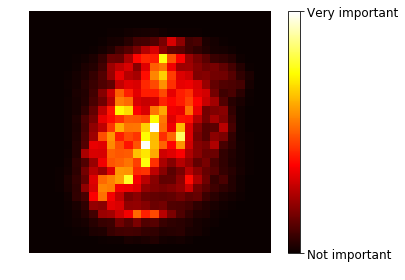

In [29]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

Random Forests are very handy to get a quick understanding of what features
actually matter, in particular if you need to perform feature selection.

# Boosting

*Boosting* (originally called *hypothesis boosting*) refers to any Ensemble method that
can combine several weak learners into a strong learner. The general idea of most
boosting methods is to train predictors sequentially, each trying to correct its prede‐
cessor. There are many boosting methods available, but by far the most popular are *AdaBoost* (short for *Adaptive Boosting*) and *Gradient Boosting*) Let's start with Ada-Boost.

## AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention
to the training instances that the predecessor underfitted. This results in new predic‐
tors focusing more and more on the hard cases. This is the technique used by Ada‐
Boost.

For example, to build an AdaBoost classifier, a first base classifier (such as a Decision
Tree) is trained and used to make predictions on the training set. The relative weight
of misclassified training instances is then increased. A second classifier is trained
using the updated weights and again it makes predictions on the training set, weights
are updated, and so on (see figure on p. 202.

The figure below shows the decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularized SVM classifier
with an RBF kernel).

**Note**: This is just for illustrative purposes. SVMs are generally not good base predictors for AdaBoost because they are slow and tend to be unstable with AdaBoost.

The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and
so on. The plot on the right represents the same sequence of predictors except that
the learning rate is halved (i.e., the misclassified instance weights are boosted half as
much at every iteration). As you can see, this sequential learning technique has some
similarities with Gradient Descent, except that instead of tweaking a single predictor’s
parameters to minimize a cost function, AdaBoost adds predictors to the ensemble,
gradually making it better.



Saving figure boosting_plot


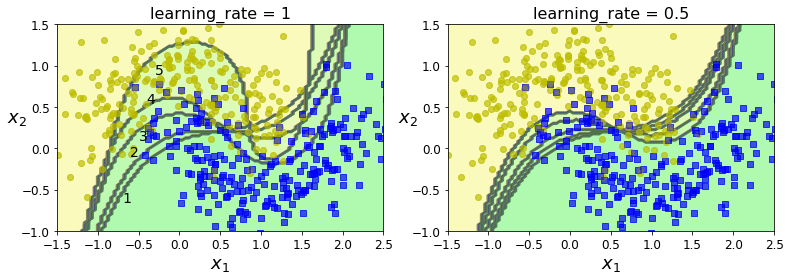

In [30]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

save_fig("boosting_plot")
plt.show()

Once all predictors are trained, the ensemble makes predictions very much like bag‐
ging or pasting, except that predictors have different weights depending on their
overall accuracy on the weighted training set.

**Note**: There is one important drawback to this sequential learning techni‐
que: it cannot be parallelized (or only partially), since each predic‐
tor can only be trained after the previous predictor has been
trained and evaluated. As a result, it does not scale as well as bag‐
ging or pasting.

Let's take a closer look at the AdaBoost algorithm. Each instance weight wi is initially set to (1/m). A first predictor is trained and its weighted error rate r1 is computed on the training set.

*Weighted Error Rate of the jth predictor*

rj = summ-->1( wi ) [yhatij =/= yi] / summ-->1( wi )
-  where yhatij is the jth predictor's prediction for the ith instance.

The predictor's weight αj is then computed using the equation below, where η is the learning rate hyperparameter (defaults to 1). The more accurate the predictor is, the
higher its weight will be. If it is just guessing randomly, then its weight will be close to
zero. However, if it is most often wrong (i.e., less accurate than random guessing),
then its weight will be negative.

*Predictor Weight*

-  αj = η * log( (1-rj) / rj )

Next the instance weights are updated using the equation below: the misclassified instances are boosted.

*Weight update rule*

-  for i=1,2,...,m
-  wi: 
    -  wi        if yhatij = yi
    -  wiexp(αj) if yhatij =/= yi
    
Then all the instance weights are normalized (ie divided by summ-->1(wi))

Finally, a new predictor is trained using the updated weights, and the whole process is
repeated (the new predictor’s weight is computed, the instance weights are updated,
then another predictor is trained, and so on). The algorithm stops when the desired
number of predictors is reached, or when a perfect predictor is found.

To make predictions, AdaBoost simply computes the predictions of all the predictors
and weighs them using the predictor weights αj
. The predicted class is the one that
receives the majority of weighted votes:

*AdaBoost Predictions*

-  yhat(x) = argmaxk sumj=1-->N (αj) [yhatj(x) = k] where N is the number of predictors.

Sklearn actually uses a multiclass version of AdaBoost called SAMME (which stands for *Stagewise Additive Modeling using a Multiclass Exponential loss function*). When there are just two classes, SAMME is equivalent to AdaBoost. Moreover, if the
predictors can estimate class probabilities (i.e., if they have a predict_proba()
method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands
for “Real”), which relies on class probabilities rather than predictions and generally
performs better.

The following code trains an AdaBoost classifier based on 200 *Decision Stumps* using
Scikit-Learn’s AdaBoostClassifier class (as you might expect, there is also an Ada
BoostRegressor class). A Decision Stump is a Decision Tree with max_depth=1—in
other words, a tree composed of a single decision node plus two leaf nodes. This is
the default base estimator for the AdaBoostClassifier class:

In [31]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

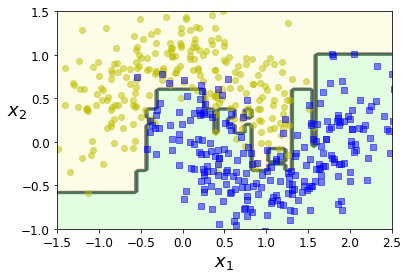

In [32]:
plot_decision_boundary(ada_clf, X, y)

**Note**: If your AdaBoost ensemble is overfitting the training set, you can
try reducing the number of estimators or more strongly regularizing the base estimator.

In [33]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

# Gradient Boosting

Another very popular Boosting algorithm is *Gradient Boosting*. 7 Just like AdaBoost,
Gradient Boosting works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, this method tries to fit the new predictor to the *residual
errors* made by the previous predictor.

Let’s go through a simple regression example using Decision Trees as the base predic‐
tors (of course Gradient Boosting also works great with regression tasks). This is
called *Gradient Tree Boosting*, or *Gradient Boosted Regression Trees (GBRT)*. First, let’s
fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic train‐
ing set):

In [34]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Now train a second DecisionTreeRegressor on the residual errors made by the first predictor:

In [36]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Then we train a third regressor on the residual errors made by the second predictor:

In [37]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Now we have an ensemble containing three trees. It can make predictions on a new
instance simply by adding up the predictions of all the trees:

In [38]:
X_new = np.array([[0.8]])

In [39]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,
                                              tree_reg2,
                                              tree_reg3))

In [40]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the
ensemble’s predictions in the right column. In the first row, the ensemble has just one
tree, so its predictions are exactly the same as the first tree’s predictions. In the second
row, a new tree is trained on the residual errors of the first tree. On the right you can
see that the ensemble’s predictions are equal to the sum of the predictions of the first
two trees. Similarly, in the third row another tree is trained on the residual errors of
the second tree. You can see that the ensemble’s predictions gradually get better as
trees are added to the ensemble.

Saving figure gradient_boosting_plot


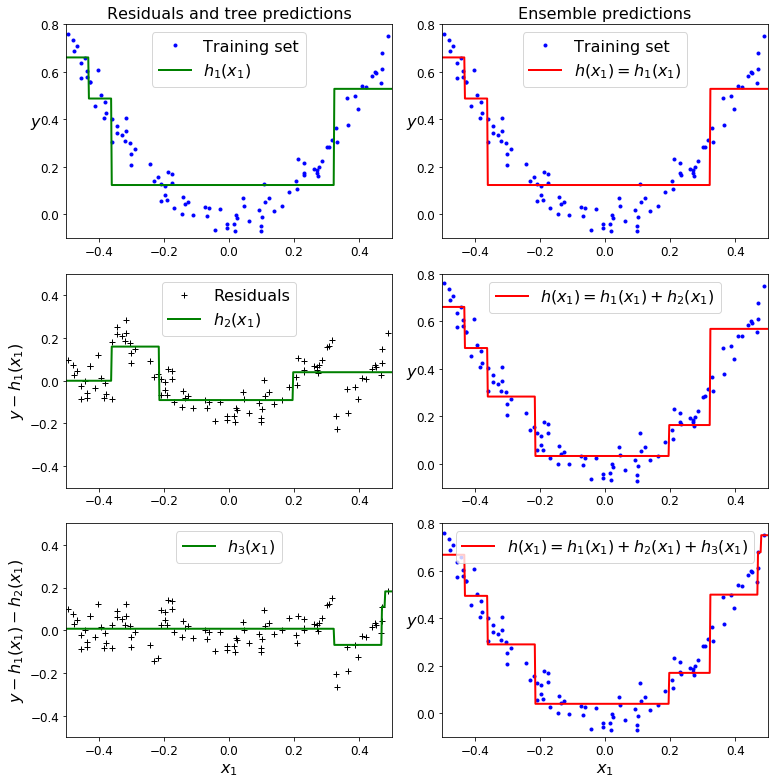

In [41]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

A simpler way to train GBRT ensembles is to use Scikit-Learn’s GradientBoostingRe
gressor class. Much like the RandomForestRegressor class, it has hyperparameters to
control the growth of Decision Trees (e.g., max_depth, min_samples_leaf, and so on),
as well as hyperparameters to control the ensemble training, such as the number of
trees (n_estimators). The following code creates the same ensemble as the previous
one:

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                learning_rate=1.0,
                                random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

The learning_rate hyperparameter scales the contribution of each tree. If you set it
to a low value, such as 0.1, you will need more trees in the ensemble to fit the train‐
ing set, but the predictions will usually generalize better. This is a regularization tech‐
nique called *shrinkage*. The figure below shows  two GBRT ensembles trained with a low
learning rate: the one on the left does not have enough trees to fit the training set,
while the one on the right has too many trees and overfits the training set.

In [43]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

Saving figure gbrt_learning_rate_plot


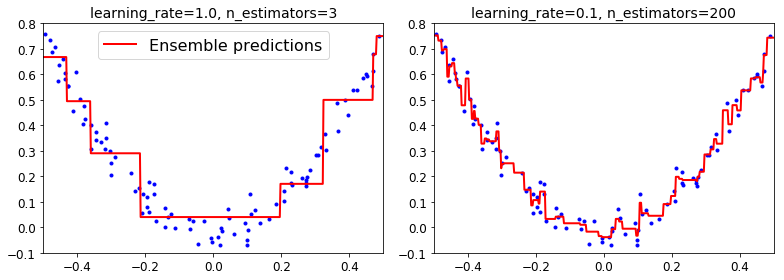

In [44]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

In order to find the optimal number of trees, you can use early stopping (see Chapter 4). A simple way to implement this is to use the staged_predict() method: it
returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). The following code trains a GBRT ensemble with
120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal
number of trees:

### Gradient Boosting with Early Stopping

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120,
                                random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=bst_n_estimators,
                                      random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=117, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

The validation errors are represented on the left of the figure below, and the best model's predictions are represented on the right.

In [46]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


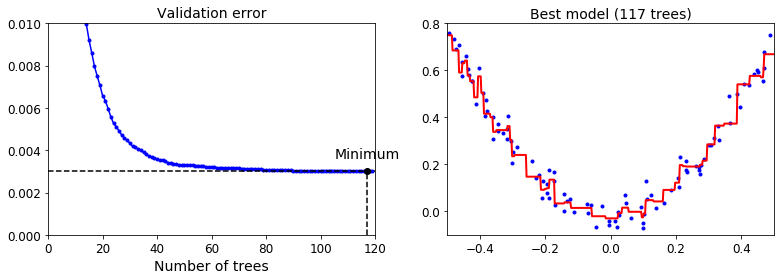

In [47]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

It is also possible to implement early stopping by actually stopping training early
(instead of training a large number of trees first and then looking back to find the
optimal number). You can do so by setting warm_start=True, which makes ScikitLearn keep existing trees when the fit() method is called, allowing incremental
training. The following code stops training when the validation error does not
improve for five iterations in a row:

In [48]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True,
                                random_state=42)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping

In [49]:
print(gbrt.n_estimators)

105


In [50]:
print('Minimum validation MSE:', min_val_error)

Minimum validation MSE: 0.003023701609089896


I'm guessing with this strategy that the optimum n_estimators is n_estimators - 5 because it took 5 iterations of your min_val_error not decreasing, so those 5 weren't as good as the one before them.

The GradientBoostingRegressor class also supports a subsample hyperparameter,
which specifies the fraction of training instances to be used for training each tree. For
example, if subsample=0.25, then each tree is trained on 25% of the training instan‐
ces, selected randomly. As you can probably guess by now, this trades a higher bias
for a lower variance. It also speeds up training considerably. This technique is called *Stochastic Gradient Boosting*.

**Note**: It is possible to use Gradient Boosting with other cost functions.
This is controlled by the loss hyperparameter (see Scikit-Learn’s
documentation for more details).

### Using XGBoost
It is worth noting that an optimized implementation of Gradient Boosting is available
in the popular python library *XGBoost*, which stands for Extreme Gradient Boosting. This package was initially developed by Tianqi Chen as part of the Distributed (Deep)
Machine Learning Community (DMLC),  and it aims at being extremely fast, scalable
and portable. In fact, XGBoost is often an important component of the winning
entries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s:

In [51]:
'''
xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)
'''

XGBoost also offers several nice features, such as automatically taking care of early stopping:

In [53]:
'''
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)
'''

'\nxgb_reg.fit(X_train, y_train,\n            eval_set=[(X_val, y_val)], early_stopping_rounds=2)\ny_pred = xgb_reg.predict(X_val)\nval_error = mean_squared_error(y_val, y_pred)\nprint("Validation MSE:", val_error)\n'

# Catboost

In [55]:
# Replace XGBoost with Catboost here.

# Stacking

The last Ensemble method we will discuss in this chapter is called *stacking* (short for *stacked generalization*).  It is based on a simple idea: instead of using trivial functions
(such as hard voting) to aggregate the predictions of all predictors in an ensemble,
why don’t we train a model to perform this aggregation?
A figure from the book shows such an
ensemble performing a regression task on a new instance. Each of the bottom three
predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor
(called a *blender*, or a *meta learner*) takes these predictions as inputs and makes the
final prediction (3.0).

To train the blender, a common approach is to use a hold-out set. Let’s see how it
works. First, the training set is split in two subsets. The first subset is used to train the
predictors in the first layer. Next, the first layer predictors are used to make predictions on the second (held-out)
set. This ensures that the predictions are “clean,” since the predictors
never saw these instances during training. Now for each instance in the hold-out set there are three predicted values. We can create a new training set using these predic‐
ted values as input features (which makes this new training set three-dimensional),
and keeping the target values. The blender is trained on this new training set, so it
learns to predict the target value given the first layer’s predictions. It is actually possible to train several different blenders this way (e.g., one using Lin‐
ear Regression, another using Random Forest Regression, and so on): we get a whole
layer of blenders. The trick is to split the training set into three subsets: the first one is
used to train the first layer, the second one is used to create the training set used to
train the second layer (using predictions made by the predictors of the first layer),
and the third one is used to create the training set to train the third layer (using pre‐
dictions made by the predictors of the second layer). Once this is done, we can make
a prediction for a new instance by going through each layer sequentially. Unfortunately, Scikit-Learn does not support stacking directly, but it is not too hard
to roll out your own implementation (see the following exercises). Alternatively, you
can use an open source implementation such as breww (available at https://github.com/viisar/brew).